# Determining Student Knowledge Status

### Introduction

Understanding how student study methods and examination results affect the retention of information is essential to create better teaching and learning methodologies. At a university in Turkey, Ph.D students collected data on undergraduate students' understanding of Electrical DC Machines. They utilized five normalized characteristics to determine the knowledge level of students from very low to high. The five variables included the amount of study time, number of repetitions and exam performance for goal object materials as well as the amount of study time and exam performance for related objects with the goal object.

Through this project, we propose to answer the following question: 

> *Given the degree of preparation and examination results of a student, what will be the knowledge retention level of said student?* 

We aim to achieve this by training a model that, given the five aforementioned characteristics, will classify the knowledge level of a student. 

### Preliminary Exploratory Data Analysis

In [30]:
## Run this cell before continuing
library(tidyverse)
library(readxl)
library(repr)
library(tidymodels)

The dataset we will be using is the **User Knowledge Modeling Data Set** provided by the *UCI Machine Learning Repository*, linked [here](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

This dataset has the following variables:
- `STG`: The degree of study time for goal object materials
- `SCG`: The degree of repetition number of user for goal object materials
- `STR`: The degree of study time of user for related objects with goal object
- `LPR`: The exam performance of user for related objects with goal object
- `PEG`: The exam performance of user for goal objects
- `UNS`: The knowledge level of user

Utilizing the first five variables, we aim to predict the sixth variable, `UNS`, which is a student's knowledge level. The knowledge level variable has one of four possible labels: `High`, `Middle`, `Low` and `Very Low`.

Before doing any analysis, we first need to obtain our training and testing data and separate the two in order to avoid overfitting and foster generalizability. The dataset is already split into training and testing data, so we do not have to perform an initial split to separate the data. Now, let's read in our training and testing data:

In [31]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"

download.file(url, destfile = "data/Data_User_Modeling_Dataset.xls")

knowledge_training <- read_excel("data/Data_User_Modeling_Dataset.xls", sheet = 2) %>%
    select(STG:UNS)

knowledge_testing <- read_excel("data/Data_User_Modeling_Dataset.xls", sheet = 3) %>%
    select(STG:UNS)

head(knowledge_training, n = 5)
head(knowledge_testing, n = 5)

New names:
* `` -> ...7
* `` -> ...8

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High


Note that the first five variables are already normalized to be in the range [0, 1], where a higher number is associated with a higher degree of preparation or a higher exam performance. This will actually make things easier for us when training our classification model!

Additionaly, note that out of all category names, only `STG` and `STR` properly communicate what they represent. Let's change the variable names to the following, which better communicate what they represent:
- `STG`: Study Time degree for Goal object materials
- `RNG`: Repetition Number degree for Goal object materials
- `STR`: Study Time degree for Related objects with goal object materials
- `EPR`: Exam Performance for Related objects with goal objects
- `EPG`: Exam Performance for Goal object
- `SKL`: Student Knowledge Level

In [32]:
knowledge_testing <- knowledge_testing %>%
    rename(RNG = SCG,
           EPR = LPR, 
           EPG = PEG,
           SKL = UNS)

knowledge_training <- knowledge_training %>%
    rename(RNG = SCG,
           EPR = LPR, 
           EPG = PEG,
           SKL = UNS)

head(knowledge_training, n = 5)
head(knowledge_testing, n = 5)

STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low


STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High


That's better. Let's continue tidying up the data! 

As we can see from the above dataframes, the labelling done on the test and training sets are different! In particular, the label representing a very low knowledge level varies. In the test dataset it's 'Very Low' and in the training dataset it's 'very_low'.

This may not be the only difference, so let's compare the labels present in both the test and training datasets.

In [33]:
knowledge_training %>%
    pull(SKL) %>%
    unique()

[1] "very_low" "High"     "Low"      "Middle"

In [34]:
knowledge_testing %>%
    pull(SKL) %>%
    unique()

[1] "Very Low" "Low"      "High"     "Middle"

As we can see, the only difference between the two sets of labels are for the very low category of knowlege. A few changes will fix this right up and make the data easier to work with:
- Firstly, we will remove the underscore in the label 'very_low' in the training dataset
- Secondly, we will transform all knowledge level (SKL) labels to lower case
- Then we'll transform the knowledge level (SKL) column to be a factor column (instead of the current character column)
- And, finally, we'll order the different levels to be in ascending order

In [35]:
# remove the underscore
knowledge_training <- knowledge_training %>%
    mutate(SKL = replace(knowledge_training$SKL, knowledge_training$SKL == "very_low", "very low"))

# change label to a factor
knowledge_training <- knowledge_training %>%
    mutate(SKL = as_factor(tolower(SKL)))

knowledge_training %>%
    pull(SKL) %>%
    levels()

[1] "very low" "high"     "low"      "middle"

The levels for the training set look good, let's just order them:

In [36]:
knowledge_training$SKL <- factor(knowledge_training$SKL, levels=c("very low", "low", "middle", "high"))
knowledge_training %>%
    pull(SKL) %>%
    levels()

[1] "very low" "low"      "middle"   "high"

Onto the testing dataset:

In [37]:
knowledge_testing <- knowledge_testing %>%
    mutate(SKL = as_factor(tolower(SKL)))

knowledge_testing %>%
    pull(SKL) %>%
    levels()

[1] "very low" "low"      "high"     "middle"

Let's order the levels:

In [38]:
knowledge_testing$SKL <- factor(knowledge_testing$SKL, levels=c("very low", "low", "middle", "high"))
knowledge_testing %>%
    pull(SKL) %>%
    levels()

[1] "very low" "low"      "middle"   "high"

Perfect! Now that our class labels are consistent across datasets, let's have a final look:

In [39]:
head(knowledge_training, n = 4)

STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very low
0.08,0.08,0.10,0.24,0.90,high
0.06,0.06,0.05,0.25,0.33,low
0.10,0.10,0.15,0.65,0.30,middle


In [40]:
head(knowledge_testing, n = 4)

STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,very low
0.05,0.05,0.55,0.60,0.14,low
0.08,0.18,0.63,0.60,0.85,high
0.20,0.20,0.68,0.67,0.85,high


There, that's more like it. Our data is now tidy, that is: 
- each row is a single observation (a student)
- each column is a single variable, and 
- each cell contains a single value (normalized degree of study or exam performance)

Now that we have properly wrangled the data, we can proceed to do the following:
1. lock our test data in an imaginary box, only to be opened when evaluating the model we will build
2. summarize our training data 
3. explore and visualize patterns/trends within the data

After which, we will build our model.

First things first, let's summarize the data to gain some more insight. To do this, we create a table that will do the following for each knowledge level:
1. report the number of observations
2. report the predictor means, and 
3. report the number of rows that have missing data 

In [41]:
summary_table <- knowledge_training %>%
    group_by(SKL) %>%
    summarize(class_count = n(),
              mean_stg = mean(STG),
              mean_rng = mean(RNG),
              mean_str = mean(STR),
              mean_epr = mean(EPR),
              mean_epg = mean(EPG),
              missing_rows = sum(is.na(SKL))) %>%
    arrange(mean_epg)
summary_table

`summarise()` ungrouping output (override with `.groups` argument)



SKL,class_count,mean_stg,mean_rng,mean_str,mean_epr,mean_epg,missing_rows
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
very low,24,0.3057917,0.1981250,0.3662500,0.3587500,0.09083333,0
low,83,0.3211446,0.3370000,0.4307229,0.4973494,0.23762651,0
middle,88,0.3999773,0.3679205,0.5068182,0.3428409,0.54238636,0
high,63,0.4216508,0.4231905,0.5016667,0.5012698,0.77253968,0


Wonderful! It appears that our target variable contains no missing values.

Additionally, if you look at the different predictor means in relation to the student's knowledge level, we generally see that as the predictor mean increases, the student's knowledge level increases as well (with the exception of `EPR` which is a student's exam performance for related objects)! This gives us some intuition that we may see a positive relationship between these predictors and a student's knowledge level.

Let's visualize the different predictor - student knowlege level relationships to get a better understanding.

To do this, we'll first need to convert the summary table above into long format and get rid of the `class_count` and `missing_rows` columns, which we won't need. We will create two new columns:
- `predictor_name` which will be the name of the predictor mean
- `mean` which will be the mean for the predictor

In [42]:
summary_long <- summary_table %>%
    select(-class_count, -missing_rows)%>%
    pivot_longer(cols = mean_stg:mean_epg,
                 names_to = "predictor_name",
                 values_to = "mean")

head(summary_long, n = 5)

SKL,predictor_name,mean
<fct>,<chr>,<dbl>
very low,mean_stg,0.30579167
very low,mean_rng,0.19812500
very low,mean_str,0.36625000
very low,mean_epr,0.35875000
very low,mean_epg,0.09083333


Now that our summary table is in long format, we can proceed to visualize the relationships between the different predictors and the student's knowledge level.

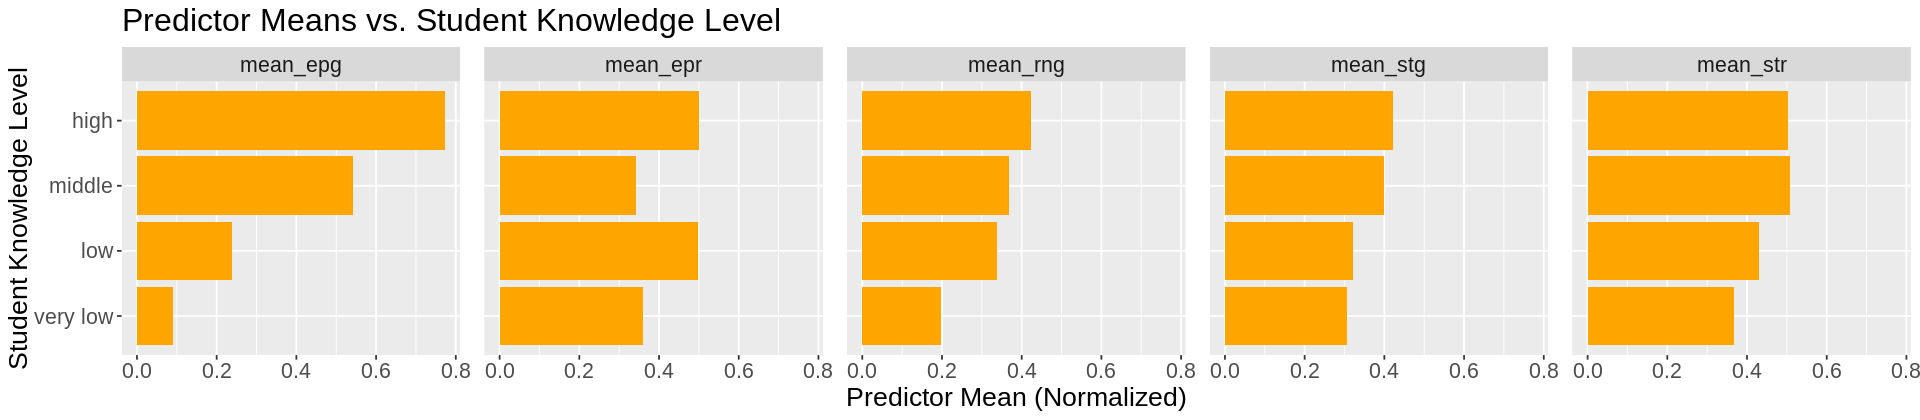

In [43]:
options(repr.plot.width = 16, repr.plot.height = 3.5)

summary_long %>%
    ggplot(aes(x = reorder(SKL, mean), y = mean)) + 
    geom_bar(stat='identity', fill="orange") + 
    facet_wrap(~predictor_name, nrow = 1) + 
    ggtitle("Predictor Means vs. Student Knowledge Level") +
    xlab("Student Knowledge Level") + 
    ylab("Predictor Mean (Normalized)") + 
    theme(text = element_text(size = 16),
          panel.spacing = unit(1, "lines")) + 
    coord_flip()

From the above plot, we note that there is a positive relationship between a student's knowledge level, `SKL`, and the following predictors:
- the degree of study time for goal object materials, `STG`
- the degree of repetition number for goal object materials, `RNG`
- the exam performance for goal object materials, `EPG`

Conversely, we note that there is no apparent relationship between a student's knowledge level, `SKL`, and the following predictors:
- the degree of study time for related object materials, `STR` and
- the exam performance for related materials, `EPR`

Essentially, the visualization suggests that, although there is an apparent relationship between a student's knowledge level and their preparation degree and examination results for goal object materials, there is little to no relationship between preparation degree and examination performance for related obect materials. Despite this, we will still include information about related object materials to train our model because...

**Use 2 references/citations here**

Now let's try another exploratory visualization, this time using a scatterplot. We want to see how a combination of our variables dictate the distribution of our varied student knowledge levels. Because we have 5 predictors, we want to combine them in a way that is easier to plot on a graph. A logical grouping of our variables would be into:
1. `prep` Preparation Variables, such as `STG`, `RNG`, and `STR`; and
2. `exam` Examination Performance Variables, such as `EPG` and `EPR`.

In order to obtain these columns, we will simply take the mean of the listed variables for each observation.

We wish to plot our `prep` variables on the x-axis and `exam` variables on the y-axis, since it follows that exam performance is influenced by how much the student prepares for it. Additionally, we wish to color each point on our scatterplot according to the student knowledge level to see the distribution of these points.

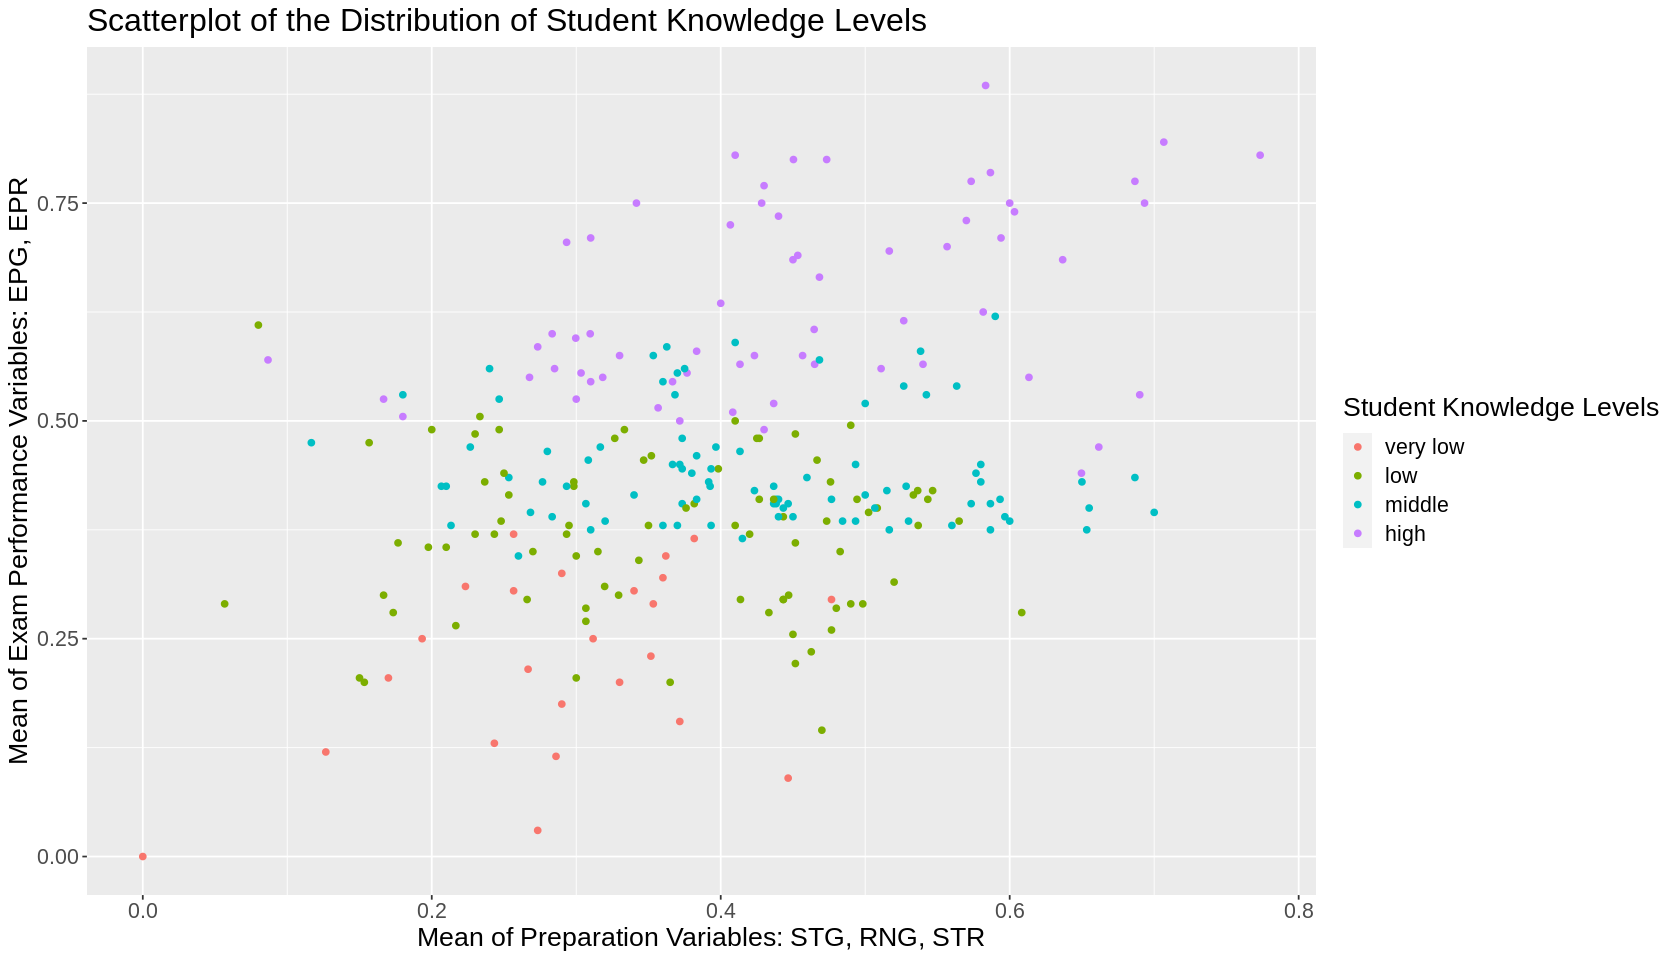

In [51]:
# Adding prep and exam columns to our dataset for visualization
knowledge_viz <- knowledge_training %>%
    mutate(prep = (STG + RNG + STR) / 3, exam = (EPG + EPR) / 2) %>%
    select(SKL, prep, exam)

# Displaying our plot
options(repr.plot.width = 14, repr.plot.height = 8)
knowledge_viz %>%
    ggplot(aes(x=prep, y=exam, color=SKL)) +
    geom_point() + theme(text = element_text(size = 16)) +
    labs(title="Scatterplot of the Distribution of Student Knowledge Levels", 
         x="Mean of Preparation Variables: STG, RNG, STR",
         y="Mean of Exam Performance Variables: EPG, EPR",
         color="Student Knowledge Levels")

We see from this visualization that there certainly is a division between the distributions of our varied student knowledge levels. 'very low' observations are toward the bottom left of the graph. 'low' observations are found towards the bottom center of the graph, while 'middle' observations are located a bit higher than these, still at the center. Lastly, our 'high' observations are seen at the top right of our graph. This gives us a clue that when our predictor variables increase, our student knowledge level increases as well: from very low to low to middle to high.

Finally, we can now start building our model!

Let's begin by selecting the type of model we will be building. Seeing as we aim to classify a student's knowledge level into one of four categories, our problem is one of classification by nature. While there are numerous classification algorithms available, we will use the K-Nearest Neighbors algorithm.

It was mentioned in our modeling dataset that they also used the k-nearest neighbor algorithm to model their data. This algorithm chooses the "nearest" or "most similar" observations in our training set to predict labels for any test observations we may give our model. 'K' refers to a specific number that we must choose. For example, if we choose the number 3, then we take the 3 nearest observations and use their labels (or majority of their labels) to dictate the category of the observation we are currently handling.

Before we begin building our k-nearest neighbor classification model, we need to find our best 'K'.

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 7)
set.seed(18)

# Create the knn recipe 
knn_recipe <- recipe(SKL ~ STG + RNG + STR + EPR + EPG, data = knowledge_training)

# Create the knn spec to find the best k-value 
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Create the v-fold 
knowledge_vfold <- vfold_cv(knowledge_training, v = 5, strata = SKL)

# Create the workflow and collect statistics
knn_results <- workflow() %>%
    add_recipe(knn_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = knowledge_vfold, grid = 10) %>%
    collect_metrics()

# Calculate and plot accuracy estimates
accuracies <- knn_results %>%
    filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) + 
    geom_point() +
    geom_line() +
    ggtitle("Accuracy Estimate vs Neighbors") +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 30, by = 1)) +
    scale_y_continuous(limits = c(0.7, 0.9)) +
    theme(text = element_text(size = 18))
accuracy_versus_k

Based on the plot above, we see that $k = 4$ would be a good choice for our $k$ since this gives us the highest accuracy estimate. Additionally, choosing values close to $k = 4$ would not significantly decrease our accuracy.

Now that we have our best choice of $k$, let's use it to create our final model. 

In [ ]:
set.seed(2022)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit <- workflow() %>%
    add_recipe(knn_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = knowledge_training)

knn_fit

Now that we have our final model created, let's evaluate it on our test dataset and find out how accurate it really is!

In [ ]:
set.seed(2021)

knowledge_predictions <- knn_fit %>%
    predict(knowledge_testing) %>%
    bind_cols(knowledge_testing)

head(knowledge_predictions, n = 5)

Time to evaluate the accuracy:

In [ ]:
knowledge_metrics <- knowledge_predictions %>%
    metrics(truth = SKL, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

knowledge_metrics

As you can see, the accuracy of our model as evaluated on the testing dataset is around 82%. Is this good? Let's have a look at a confusion matrix before we answer this:

In [ ]:
knowledge_predictions %>%
    conf_mat(truth = SKL, estimate = .pred_class)

notes:
- very low is confused for low many times; potentially due to the undersampling of very low (only 23 observations while the others have around 80)
- middle confused for low 

not dealing with Malignant/Benign case so 82% is pretty good imo... thoughts?

### Discussion